In [199]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [200]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [201]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [202]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


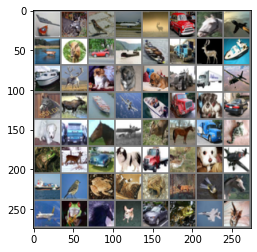

plane deer  bird  plane deer  car   horse plane deer  deer  car   ship  ship  truck deer  ship  ship  deer  dog   dog   dog   truck truck plane horse deer  ship  plane ship  truck dog   car   dog   truck horse plane deer  horse truck cat   frog  deer  car   dog   truck deer  dog   plane ship  bird  frog  cat   frog  deer  bird  horse plane frog  horse dog   car   frog  plane cat  


In [203]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [204]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = self.pool(F.sigmoid(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.sigmoid(self.fc1(x)))
        x = self.dropout(F.sigmoid(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [205]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.1,momentum = 0):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [206]:
begin = time.time()
history, end, lrs = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:09<00:00, 67.68it/s]


Epoch [0], Time taken :11.5176, train_loss : 2.3122, train_acc: 0.1016, val_loss: 2.3054, val_acc: 0.1007


100%|██████████| 657/657 [00:10<00:00, 63.16it/s]


Epoch [1], Time taken :12.1728, train_loss : 2.3047, train_acc: 0.0976, val_loss: 2.3040, val_acc: 0.0975


100%|██████████| 657/657 [00:10<00:00, 65.14it/s]


Epoch [2], Time taken :11.9754, train_loss : 2.3036, train_acc: 0.1001, val_loss: 2.3025, val_acc: 0.1042


100%|██████████| 657/657 [00:10<00:00, 63.48it/s]


Epoch [3], Time taken :12.2262, train_loss : 2.3036, train_acc: 0.0984, val_loss: 2.3031, val_acc: 0.1036


100%|██████████| 657/657 [00:09<00:00, 65.91it/s]


Epoch [4], Time taken :11.7624, train_loss : 2.3034, train_acc: 0.0994, val_loss: 2.3032, val_acc: 0.1002


100%|██████████| 657/657 [00:09<00:00, 66.07it/s]


Epoch [5], Time taken :11.7204, train_loss : 2.3032, train_acc: 0.0976, val_loss: 2.3031, val_acc: 0.0995


100%|██████████| 657/657 [00:10<00:00, 60.20it/s]


Epoch [6], Time taken :13.0182, train_loss : 2.3031, train_acc: 0.1015, val_loss: 2.3032, val_acc: 0.0951


100%|██████████| 657/657 [00:10<00:00, 65.66it/s]


Epoch [7], Time taken :11.8392, train_loss : 2.3029, train_acc: 0.0991, val_loss: 2.3031, val_acc: 0.0983


100%|██████████| 657/657 [00:09<00:00, 67.46it/s]


Epoch [8], Time taken :11.5659, train_loss : 2.3030, train_acc: 0.0996, val_loss: 2.3028, val_acc: 0.0989


100%|██████████| 657/657 [00:10<00:00, 62.53it/s]


Epoch [9], Time taken :12.2630, train_loss : 2.3030, train_acc: 0.0990, val_loss: 2.3029, val_acc: 0.0965


100%|██████████| 657/657 [00:10<00:00, 65.59it/s]


Epoch [10], Time taken :11.8043, train_loss : 2.3029, train_acc: 0.0990, val_loss: 2.3026, val_acc: 0.1020


100%|██████████| 657/657 [00:10<00:00, 64.88it/s]


Epoch [11], Time taken :12.1741, train_loss : 2.3029, train_acc: 0.0998, val_loss: 2.3029, val_acc: 0.1004


100%|██████████| 657/657 [00:10<00:00, 63.99it/s]


Epoch [12], Time taken :12.0553, train_loss : 2.3029, train_acc: 0.1009, val_loss: 2.3028, val_acc: 0.1061


100%|██████████| 657/657 [00:10<00:00, 63.49it/s]


Epoch [13], Time taken :12.1280, train_loss : 2.3027, train_acc: 0.1001, val_loss: 2.3031, val_acc: 0.0948


100%|██████████| 657/657 [00:10<00:00, 59.95it/s]


Epoch [14], Time taken :12.7722, train_loss : 2.3028, train_acc: 0.1001, val_loss: 2.3028, val_acc: 0.1016


100%|██████████| 657/657 [00:10<00:00, 63.36it/s]


Epoch [15], Time taken :12.4792, train_loss : 2.3029, train_acc: 0.0994, val_loss: 2.3025, val_acc: 0.0974


100%|██████████| 657/657 [00:09<00:00, 68.17it/s]


Epoch [16], Time taken :11.7438, train_loss : 2.3028, train_acc: 0.0991, val_loss: 2.3028, val_acc: 0.1029


100%|██████████| 657/657 [00:10<00:00, 64.28it/s]


Epoch [17], Time taken :11.9931, train_loss : 2.3028, train_acc: 0.1016, val_loss: 2.3029, val_acc: 0.0971


100%|██████████| 657/657 [00:09<00:00, 67.52it/s]


Epoch [18], Time taken :11.4984, train_loss : 2.3027, train_acc: 0.1006, val_loss: 2.3028, val_acc: 0.1058


100%|██████████| 657/657 [00:09<00:00, 67.81it/s]


Epoch [19], Time taken :11.4506, train_loss : 2.3029, train_acc: 0.0985, val_loss: 2.3030, val_acc: 0.1009


100%|██████████| 657/657 [00:10<00:00, 63.52it/s]


Epoch [20], Time taken :12.0998, train_loss : 2.3027, train_acc: 0.0986, val_loss: 2.3028, val_acc: 0.0939


100%|██████████| 657/657 [00:09<00:00, 67.35it/s]


Epoch [21], Time taken :11.5407, train_loss : 2.3028, train_acc: 0.1012, val_loss: 2.3027, val_acc: 0.0956


100%|██████████| 657/657 [00:09<00:00, 66.76it/s]


Epoch [22], Time taken :12.1695, train_loss : 2.3027, train_acc: 0.1000, val_loss: 2.3028, val_acc: 0.0995


100%|██████████| 657/657 [00:09<00:00, 67.72it/s]


Epoch [23], Time taken :11.4684, train_loss : 2.3028, train_acc: 0.0980, val_loss: 2.3030, val_acc: 0.0925


100%|██████████| 657/657 [00:09<00:00, 68.29it/s]


Epoch [24], Time taken :11.3865, train_loss : 2.3027, train_acc: 0.0994, val_loss: 2.3026, val_acc: 0.1058


100%|██████████| 657/657 [00:10<00:00, 63.07it/s]


Epoch [25], Time taken :12.1799, train_loss : 2.3028, train_acc: 0.0998, val_loss: 2.3029, val_acc: 0.1032


100%|██████████| 657/657 [00:09<00:00, 67.82it/s]


Epoch [26], Time taken :11.4182, train_loss : 2.3028, train_acc: 0.1021, val_loss: 2.3028, val_acc: 0.1029


100%|██████████| 657/657 [00:09<00:00, 67.24it/s]


Epoch [27], Time taken :11.5161, train_loss : 2.3027, train_acc: 0.0991, val_loss: 2.3029, val_acc: 0.0984


100%|██████████| 657/657 [00:10<00:00, 62.41it/s]


Epoch [28], Time taken :12.3080, train_loss : 2.3028, train_acc: 0.0983, val_loss: 2.3024, val_acc: 0.1051


100%|██████████| 657/657 [00:09<00:00, 68.34it/s]


Epoch [29], Time taken :11.5605, train_loss : 2.3028, train_acc: 0.0979, val_loss: 2.3030, val_acc: 0.0983
Finished Training in 358.23629117012024secs


In [207]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

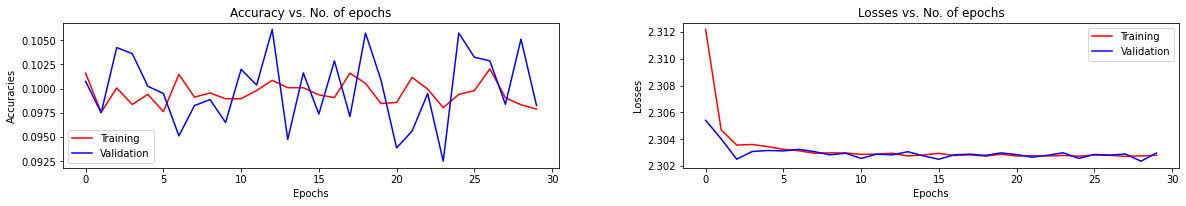

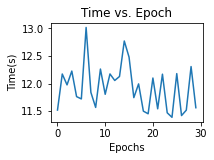

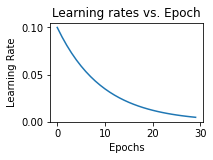

In [208]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [209]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [210]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [211]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 1.8 %
Accuracy for class: car   is 15.6 %
Accuracy for class: bird  is 7.6 %
Accuracy for class: cat   is 2.6 %
Accuracy for class: deer  is 10.9 %
Accuracy for class: dog   is 6.9 %
Accuracy for class: frog  is 12.2 %
Accuracy for class: horse is 13.2 %
Accuracy for class: ship  is 20.3 %
Accuracy for class: truck is 12.8 %
